# Technology Conference Aggregation and Analysis Project
### Data Ingest and Processing
### April 8, 2020

## Importing Modules and Defining Custom Functions
For this project, I chose to primarily use the Python requests modules to interact with several conference websites and BeautifulSoup and Pandas to parse and manipulate data. In some cases where rendering of client-side JavaScript was required to interact with pages, I used Selenium webdriver to access data through an automated headless Firefox browser window. I used Azure Cosmos DB as a cloud-based database-as-a-service (DBaaS) with the Python Azure software development kit (SDK) to interact with the database where I stored intermediate results from the website mining.

I also used GeoPy to find event locations and their coordinates, cities and countries using the free Nominatim geocoder primarily against Open Street Map (OSM) with Google's geocoder API as a backup. I defined two custom functions to handle geocoding for these services, and used the country converter library to normalize country names and country ISO codes.

In [2]:
# Import modules
import azure.cosmos.cosmos_client as cosmos_client
from azure.storage.blob import BlobServiceClient
from datetime import datetime
from datetime import timedelta
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import os
import re
import json
import sys
import requests
import socket
import time
import pickle
import calendar
import Levenshtein as lev
import country_converter as coco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ColorConverter, ListedColormap
from matplotlib.patches import Polygon
from dateutil.relativedelta import relativedelta
import plotly.express as px
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)
from IPython.display import display, HTML
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Get local folder and add project folder to PATH
start_time = time.time()
workingdir = os.getcwd()
parentdir = os.path.dirname(workingdir)
sys.path.insert(0, parentdir)

# Import custom modules
from utils.visualizations import piecols, stackplots, lineplots, logplots, calmap, \
    range_cal_plot, custom_sunburst, polar_day_month, lines_and_stacks
from utils.processing import calcHours, fixCategory, cleanDescription, createSearch, createURL, \
    websiteSource, combine_cat, clean_text, diff_ratio, create_classifier_examples, summarize_cities, get_all_month_total_counts
from utils.classifiers import load_model

# Demo flag. Set to False to turn on/off additional feedback
demo = True

# Hides code in HTML output
HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Analyzing and Aggregating Data From Results
As a preliminary exploratory data analysis, I used custom Cosmos queries using the SQL API to pull data into a Pandas DataFrame in Jupyter and looked for outliers and trends. While many of the retrieved events are conferences and summits, there were many workshops and one-day classes included in the results. Because these were out of scope for what I was analyzing, I removed them from the DataFrame and then continued data normalization and processing. This included normalizing category and country names, creating unique record IDs and converting latitudes and longitudes and dates to the correct format.

In [3]:
# Set cutoff date for query
olddtg = (datetime.now() + timedelta(days=-3650)).strftime("%Y-%m-%d %H:%M:%S")
futuredtg = (datetime.now() + timedelta(days=365)).strftime("%Y-%m-%d %H:%M:%S")

# Query these items in SQL
query = {'query': 'SELECT * \
        FROM server s WHERE s.endDate >= "' + olddtg + '" AND s.endDate <= "' + futuredtg + '" AND s.latitude <> "" AND \
        CONTAINS(s.scriptname, "_detailed.py") \
        ORDER BY s.dtg DESC'}

# load configuration json and establish connection to CosmosDB
client = cosmos_client.CosmosClient(url_connection=os.environ['AZURE_COSMOS_ENDPOINT'].replace('-', '='), auth={
                                    'masterKey': os.environ['AZURE_COSMOS_MASTER_KEY'].replace('-', '=')})

options = {}
options['enableCrossPartitionQuery'] = True
options['maxItemCount'] = -1
options['MaxDegreeOfParallelism'] = -1

# Execute query and iterate over results
print('Fetching data from Cosmos DB')
result_iterable = client.QueryItems(
    os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), query, options)
resultlist = []
t1 = 0
for item in iter(result_iterable):
    try:
        resultlist += [item]
        t1 += 1
        if t1 % 10000 == 0:
            elapsed_time = int(time.time() - start_time)
            print(str(t1) + ' records retrieved... ' +
                  str(elapsed_time) + ' seconds elapsed.')
    except Exception:
        pass
print(str(len(resultlist)) +
      ' results retrieved from Cosmos DB detailed')
event_search = resultlist.copy()

# Convert results dictionary to dataframe
df = pd.DataFrame(event_search)
print(str(len(df)) + ' rows in converted dataframe. Processing results into best merged answer...')

# Drop non-conference events
df['name'] = df['name'].fillna('')
blacklist = [' 101',
            ' camp ',
            ' overview',
            '(online)',
            'beginner',
            'bootcamp',
            'breakfast',
            'certification',
            'certified',
            'class',
            'collaboration session',
            'course',
            'deep dive',
            'dinner',
            'friday',
            'fundamentals',
            'hack night',
            'hackathon',
            'hands-on',
            'happy hour',
            'how to ',
            'Intro to ',
            'introduction',
            'lecture',
            'lightning talk',
            'lunch',
            'meetup',
            'meet-up',
            'monday',
            'monthly',
            'networking event',
            'pitch night',
            'saturday',
            'small group',
            'social night',
            'study group',
            'study night',
            'sunday',
            'tbd',
            'thursday',
            'training',
            'tuesday',
            'wednesday',
            'workshop']

for i in blacklist:
    df = df[-df['name'].str.lower().str.contains(i)].copy()

# Filter to raw data
df_both = df[['name', 'startDate', 'endDate', 'description', 'category', 'eventurl', 'organizer',
             'venuename', 'streetAddress', 'locality', 'region', 'country', 'zipcode', 'latitude', 
             'longitude', 'dtg', 'scriptname']].copy()

# Normalize lat/longs
df_both['latitude'] = df_both['latitude'].apply(lambda x: round(float(x), 6))
df_both['longitude'] = df_both['longitude'].apply(lambda x: round(float(x), 6))

# Create search/URL fields
df_both['contourURL'] = df_both.apply(createURL, axis=1)
df_both['category'] = df_both.apply(fixCategory, axis=1)

# Finish preparing combined dataframe
df_both['country_name'] = coco.convert(
    df_both['country'].tolist(), to='name_short', not_found=None)
df_both['contourURL'] = df_both.apply(createURL, axis=1)
df_both['category'] = df_both.apply(fixCategory, axis=1)
df_both['hours'] = df_both.apply(calcHours, axis=1)
df_both['country'] = df_both['country'].apply(lambda x: str(x))
df_both = df_both[(df_both['country'].str.len() == 2)].copy()
HTML(df_both[['name', 'startDate', 'country_name', 'latitude', 'longitude']].head().to_html())

Fetching data from Cosmos DB
10000 records retrieved... 7 seconds elapsed.
20000 records retrieved... 15 seconds elapsed.
30000 records retrieved... 21 seconds elapsed.
40000 records retrieved... 28 seconds elapsed.
50000 records retrieved... 34 seconds elapsed.
60000 records retrieved... 42 seconds elapsed.
70000 records retrieved... 48 seconds elapsed.
80000 records retrieved... 56 seconds elapsed.
90000 records retrieved... 64 seconds elapsed.
100000 records retrieved... 71 seconds elapsed.
110000 records retrieved... 78 seconds elapsed.
120000 records retrieved... 85 seconds elapsed.
130000 records retrieved... 91 seconds elapsed.
140000 records retrieved... 98 seconds elapsed.
150000 records retrieved... 105 seconds elapsed.
160000 records retrieved... 112 seconds elapsed.
170000 records retrieved... 120 seconds elapsed.
180000 records retrieved... 127 seconds elapsed.
190000 records retrieved... 132 seconds elapsed.
200000 records retrieved... 140 seconds elapsed.
210000 records 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning:

This pattern has match groups. To actually get the groups, use str.extract.



,name,startDate,country_name,latitude,longitude
0,Agile Testing and Test Automation Summit Manila,2020-10-16 00:00:00,Philippines,14.521103,121.016650
1,International Conference on Research in Computational Intelligence and Communication Networks,2020-11-26 00:00:00,India,12.863036,77.437871
2,Exploring Blockchain in the Cultural Sector Conference,2020-10-16 00:00:00,United Kingdom,53.463375,-2.232532
3,International Conference of Innovation in Media and Visual Design,2020-09-08 00:00:00,Indonesia,-6.256331,106.618638
4,The Cyber Security Summit Pune,2020-11-05 00:00:00,India,18.546126,73.906707


## Deduplicating and Clustering
Another issue I identified in the data is that multiple sites have information on the same conference events. To address this, I used a set of functions to identify potential pairs based on geographic proximity that occur on the same days and then used Levenshtein distance to assign a string similarity to the event titles. Using this method I was able to reduce the amount of duplicates in the aggregated data set significantly.

In [4]:
# Deduplicate results
df_both.sort_values(by=['dtg'], ascending=False, inplace=True)
df_both.drop_duplicates(subset=['name', 'scriptname', 'latitude', 'longitude', 'startDate'], inplace=True)
df_both.drop_duplicates(subset=['contourURL'], inplace=True)
print(str(len(df_both)) + ' records in merged DataFrame')
for i1 in range(2):
    # Extract and index match columns
    df1 = df_both[['contourURL', 'name', 'startDate', 'country', 'latitude', 'longitude']].set_index(['startDate', 'country']).copy()
    df2 = df_both[['contourURL', 'name', 'startDate', 'country', 'latitude', 'longitude']].set_index(['startDate', 'country']).copy()
    df2.columns = ['contourURL2', 'name2', 'latitude2', 'longitude2']
    # Join and find distance / date / country matches
    dfj1 = df1.join(df2)
    dfj1 = dfj1[dfj1['contourURL'] != dfj1['contourURL2']]
    dfj1 = dfj1[((dfj1['latitude'] - dfj1['latitude2'])**2 +
                (dfj1['longitude'] - dfj1['longitude2'])**2)**0.5 < 0.01].copy()
    # Filter possible matches by string similarity
    dfj1['diff'] = dfj1.apply(diff_ratio, axis=1)
    dfj1a = dfj1[dfj1['diff'] >= .9].copy()
    # Join and find distance / date / country matches
    dfj1 = df1.join(df2)
    dfj1 = dfj1[dfj1['contourURL'] != dfj1['contourURL2']]
    dfj1 = dfj1[((dfj1['latitude'] - dfj1['latitude2'])**2 +
                (dfj1['longitude'] - dfj1['longitude2'])**2)**0.5 < 0.1].copy()
    # Filter possible matches by string similarity
    dfj1['diff'] = dfj1.apply(diff_ratio, axis=1)
    dfj1b = dfj1[dfj1['diff'] >= .95].copy()
    # Join and find distance / date / country matches
    dfj1 = df1.join(df2)
    dfj1 = dfj1[dfj1['contourURL'] != dfj1['contourURL2']]
    dfj1 = dfj1[((dfj1['latitude'] - dfj1['latitude2'])**2 +
                (dfj1['longitude'] - dfj1['longitude2'])**2)**0.5 < 0.2].copy()
    # Filter possible matches by string similarity
    dfj1['diff'] = dfj1.apply(diff_ratio, axis=1)
    dfj1c = dfj1[dfj1['diff'] >= .999].copy()
    dfj1 = pd.concat([dfj1a, dfj1b, dfj1c], ignore_index=True)
    dfj1.drop_duplicates(['contourURL', 'contourURL2'], inplace=True)
    # Build list of unique pairs
    r1 = dfj1['contourURL'].tolist()
    r2 = dfj1['contourURL2'].tolist()
    s1 = []
    s2 = []
    for i, j in zip(r1, r2):
        if j not in s1 and i not in s2:
            s1 += [i]
            s2 += [j]
    print(str(len(s1)) + ' duplicates found...')
    alldupes = list(set(s1 + s2))
    print(str(len(alldupes)) + ' unique event URLs found in dupes...')
    df_both_sub = df_both[df_both['contourURL'].isin(alldupes)].copy()
    df_both_none = df_both[~df_both['contourURL'].isin(alldupes)].copy()
    print(str(len(df_both_none)) + ' non-duped rows.')
    print(str(len(df_both_sub)) + ' duped rows to merge.')
    merged = []
    tc = 0
    # Iterate through match pairs and combine column values
    for i, j in zip(s1, s2):
        tc += 1
        dfi = df_both_sub[df_both_sub['contourURL'] == i].head(1).copy()
        dfj = df_both_sub[df_both_sub['contourURL'] == j].head(1).copy()
        if len(dfi) > 0 and len(dfj) > 0:
            if tc % 100 == 0:
                print(tc, ' | ', dfi['name'].values[0], ' | ', dfj['name'].values[0])
            if len(str(dfi['streetAddress'].values[0])) > len(str(dfj['streetAddress'].values[0])):
                dfj['latitude'] = dfi['latitude'].values[0]
                dfj['longitude'] = dfi['longitude'].values[0]
            else:
                dfi['latitude'] = dfj['latitude'].values[0]
                dfi['longitude'] = dfj['longitude'].values[0]
            dfi['category'] = '|'.join(filter(None, list(set(
                dfi['category'].values[0].split('|') + dfj['category'].values[0].split('|')))))
            dfj['category'] = dfi['category'].values[0]
            for col in dfi.columns:
                if len(str(dfi[col].values[0])) > len(str(dfj[col].values[0])):
                    dfj[col] = dfi[col].values[0]
                else:
                    dfi[col] = dfj[col].values[0]
            dfi['contourURL'] = i
            dfj['contourURL'] = j
            merged += [dfi.copy(), dfj.copy()]
    df_both = pd.concat([df_both_none] + merged, ignore_index=True)
    # Drop duplicate values
    print(str(len(df_both)) + ' records before fuzzy aggregation')
    df_both.drop_duplicates(subset="eventurl", inplace=True)
    print(str(len(df_both)) + ' records after fuzzy aggregation')
HTML(df_both[['name', 'startDate', 'locality', 'latitude', 'longitude']].head().to_html())

159371 records in merged DataFrame
4129 duplicates found...
7794 unique event URLs found in dupes...
151577 non-duped rows.
7794 duped rows to merge.
100  |  ODSC Europe | London 2017 (paid event)  |  ODSC-Europe (Paid Event)
200  |  CyberHub Summit Austin 2018  |  CyberHub Summit Austin
300  |  PyLadies Tech &amp; Coding Night - Intro to Git  |  PyLadies Tech &amp; Coding Night
400  |  HACKEth 2nd edition- (EVENT POSTPONED)  |  HACKEth 2nd edition (EVENT POSTPONED!)
500  |  Audacious Peer Coaching Circle in Omaha  |  Audacious Coaching Circle in Omaha
600  |  Wominspiration - Telecoms &amp; AI - London North Branch  |  Wominspiration - Telecoms &amp; AI - North London Branch
700  |  ScaleConf Colombia 2019  |  ScaleConf Colombia
800  |  State of AI and ML-Summer 2019  |  State of AI and ML-Summer 2019
900  |  YOW! CTO Summit 2019 - Perth  |  YOW CTO Summit
1000  |  International Conference on Fuzzy Computation Theory and Applications  |  International Conference on Neural Computation 

,name,startDate,locality,latitude,longitude
0,Agile Testing and Test Automation Summit Manila,2020-10-16 00:00:00,Pasay,14.521103,121.016650
1,International Conference on Research in Computational Intelligence and Communication Networks,2020-11-26 00:00:00,Bengaluru,12.863036,77.437871
2,Exploring Blockchain in the Cultural Sector Conference,2020-10-16 00:00:00,Manchester,53.463375,-2.232532
3,International Conference of Innovation in Media and Visual Design,2020-09-08 00:00:00,Tangerang,-6.256331,106.618638
4,The Cyber Security Summit Pune,2020-11-05 00:00:00,Pune,18.546126,73.906707


## Augmenting Categories With TF-IDF
In order to track trends in technology and security conferences and identify potentially disruptive technologies, we needed to ensure that most events had categories. However, many of the events only had names and descriptions, while a smaller percentage had categories. To overcome this, I used a machine learning model to infer categories of conference events based on conference titles and descriptions. The current model uses Term Frequency-Inverse Document Frequency (TF-IDF) and Logistic Regression with 50 possible labels, trained on the events that had them. This allowed me to augment the data with additional categories.

In [5]:
# Clean description
print('Applying processing to descriptions...')
df_both['description'] = df_both.apply(cleanDescription, axis=1)

# Select model for categorization
model, vectorizer = load_model()

# Predict category
df_both['old_category'] = df_both['category']
df_both['new_category'] = model.predict(vectorizer.transform(
    (df_both['name'] + ' ' + df_both['description']).apply(clean_text)))
df_both['new_category_proba'] = [max(p) for p in model.predict_proba(vectorizer.transform(
    (df_both['name'] + ' ' + df_both['description']).apply(clean_text)))]

# Drop low probability predictions
df_both.loc[df_both.new_category_proba < .25, "new_category"] = ""
df_both.loc[df_both.description.str.len() < 20, "new_category"] = ""

# Append new predictions
df_both['category'] = df_both.apply(combine_cat, axis=1)

# Add search string
df_both['search'] = df_both.apply(createSearch, axis=1)

# Drop duplicate values
df_both.drop_duplicates(subset="eventurl", inplace=True)
df_both.drop_duplicates(subset="contourURL", inplace=True)

# Create additional feature columns
df_both['year'] = df_both['startDate'].apply(lambda x: int(str(x)[0:4]))
df_both['days'] = (df_both.hours / 8).astype(int)
df_both['site'] = df_both.eventurl.apply(lambda x: websiteSource(x))
df_both['month'] = df_both.startDate.apply(lambda x: calendar.month_name[int(x.split('-')[1])])
df_both['day'] = df_both.startDate.apply(lambda x: calendar.day_name[datetime.strptime(x,"%Y-%m-%d %H:%M:%S").weekday()])
print(str(len(df_both)) + ' combined rows in dataframe.')
HTML(df_both[['name', 'new_category_proba', 'new_category']].head().to_html())

Applying processing to descriptions...

Dowloading from Azure Storage blob:
	tfidf-model-2020-03-05.p

Dowloading from Azure Storage blob:
	vectorizer-2020-03-05.p
155252 combined rows in dataframe.


,name,new_category_proba,new_category
0,Agile Testing and Test Automation Summit Manila,0.314280,software testing
1,International Conference on Research in Computational Intelligence and Communication Networks,0.468258,Telecommunication
2,Exploring Blockchain in the Cultural Sector Conference,0.839551,Blockchain
3,International Conference of Innovation in Media and Visual Design,0.353265,Entertainment & Media
4,The Cyber Security Summit Pune,0.286078,Security


## Visualizing and Analyzing Data
Using a number of techniques learned over the last two years, I created several custom visualizations to help better understand the data and identify any trends about technology conferences and their relationship to disruptive technology. I primarily used Plotly to generate interactive visualization that could be rendered within the Flask application

In [6]:
# Generate donut chart visualizations for different categories
print('Creating donut charts')
piecols(df_both, ['category', 'organizer', 'venuename', 'site', 'days'], 10, div=False)

Creating donut charts


In [7]:
# Plot distribution of events by weekday and month
div = polar_day_month(df_both, div=True)

# Create results dictionary
savedplots = {}
savedplots['dtg'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
savedplots['chartname'] = 'polar_day_month'

# Create stack plot of daily total entries by scriptname in dataset over time
print('Creating polar chart...')
try:
    savedplots['plotly_html'] = div
except Exception:
    savedplots['plotly_html'] = ''

# Create Cosmos DB client
client = cosmos_client.CosmosClient(url_connection=os.environ['AZURE_COSMOS_ENDPOINT'].replace('-', '='), auth={
                                    'masterKey': os.environ['AZURE_COSMOS_MASTER_KEY'].replace('-', '=')})

# Push plot data dictionary to Cosmos DB
if savedplots['plotly_html'] != '':
    print('Storing results in Cosmos DB...')
    try:
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    except Exception:
        time.sleep(20)
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    print('Data stored...')
else:
    print('Something went wrong... No data stored...')

Creating polar chart...
Storing results in Cosmos DB...
Data stored...


In [8]:
# Plot sunburst diagram of event locations
print('Creating sunburst diagram')
cols = ['country_name', 'region', 'locality']
n = 50
custom_sunburst(df_both, cols, n, div=False)

Creating sunburst diagram


Creating calendar plots

Uploading to Azure Storage as blob:
	calheatmap.png


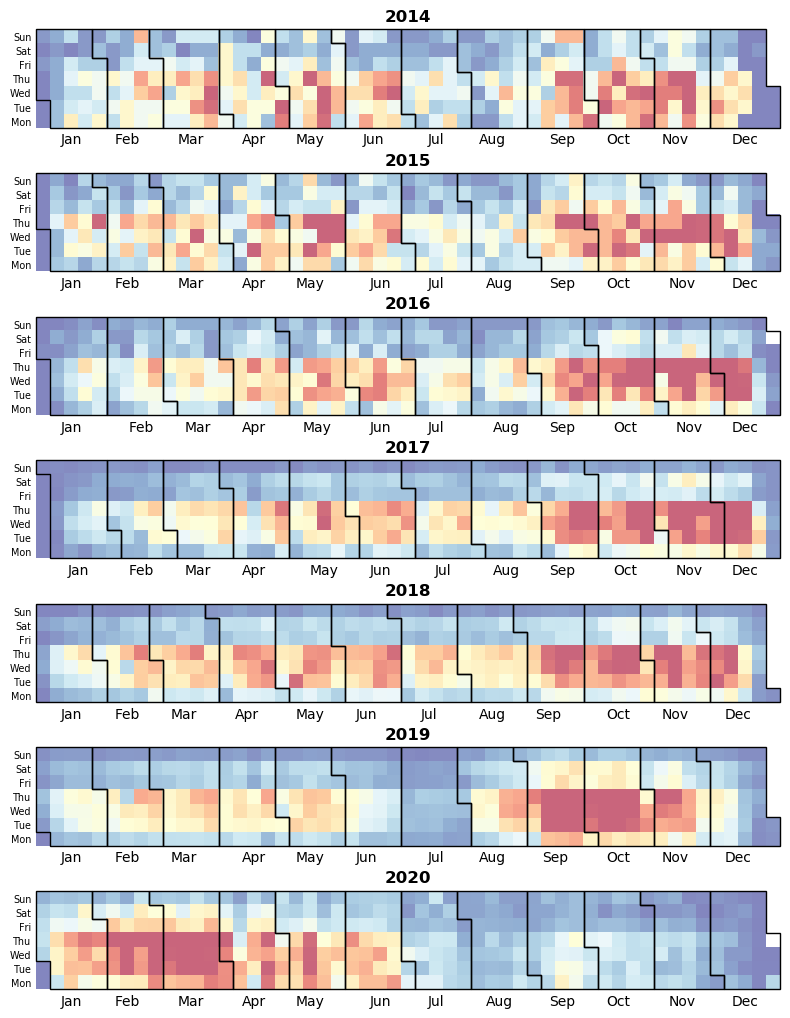

In [9]:
# Plot calendar heatmaps
print('Creating calendar plots')
img = range_cal_plot(df_both, 2014, 2021)

# Save heatmap plot as png file
img.savefig("calheatmap.png", bbox_inches="tight", dpi=150)

# Create a file path in local Documents directory to upload
local_path = ""
local_file_name_m = "calheatmap.png"
upload_file_path_m = os.path.join(local_path, local_file_name_m)

# Create the BlobServiceClient object which will be used to create a container client
blob_service_client = BlobServiceClient.from_connection_string(
    os.environ['AZURE_STORAGE_CONNECTION_STRING'])

# Create a blob client using the local file name as the name for the blob
blob_client = blob_service_client.get_blob_client(
    container=os.environ['AZURE_STORAGE_CONTAINER'], blob=local_file_name_m)

print("\nUploading to Azure Storage as blob:\n\t" + local_file_name_m)

# Upload the created file
with open(upload_file_path_m, "rb") as data:
    blob_client.upload_blob(data, overwrite=True)

In [10]:
# Set parameters for stackplot
col = 'category'
yearlist = list(range(2010,2020))
n=15

# Remove empty category values and expand events with multiple categories
df2 = df_both[(df_both[col] != '') & (df_both[col] != 'nan')].copy()
df2[col] = df2[col].str.split('|')
df2 = df2.explode(col).copy()
df2 = df2.dropna(subset=[col])
df2 = df2[(df2[col] != '') & (df2[col] != 'nan')].copy()
df2[col] = df2[col].apply(lambda x: str(x).split(' / ')[0])

# Group by category to get top category list
dfg = df2[[col, 'name']].groupby(col).count()
dfg.columns = ['count']
dfg = dfg.sort_values(by=['count'],ascending=False)
catlist = dfg.head(n).index.to_list()
        
# Create year column from creation date
df2['year'] = df2['startDate'].apply(lambda x: int(str(x)[0:4]))

# Filter to previously identified top categories and years
df2 = df2[df2[col].isin(catlist)]
df2 = df2[df2['year'].isin(yearlist)]

# Add up total events for preceding years for each year and add zero value rows for blank year/category pairs
dfg = pd.DataFrame(columns=['year', 'category', 'count'])
for year in yearlist:
    for category in catlist:
        dfp2 = df2[(df2['year'] <= year) & (df2['category'] == category)]
        dfp2 = dfp2[[col,'name']].groupby([col]).count()
        dfp2.columns = ['count']
        dfp2['year'] = year
        dfp2 = dfp2.reset_index()
        dfp2 = dfp2[['year', 'category', 'count']]
        if len(dfp2) == 0:
            dfp2 = pd.DataFrame([[year, category, 0]], columns=['year', 'category', 'count'])
        dfg = pd.concat([dfg, dfp2], ignore_index=True)
dfg = dfg.astype({"year": int, "count": int})
dfg = dfg.sort_values(by=['year'],ascending=True).reset_index().copy()

# Create list of categories in table ordered by last year event count
categories_ordered = dfg[dfg['year']==yearlist[-1]].sort_values(by=['count'],ascending=False)[col].tolist()

# Create tuple of event count arrays for each category to pass to stack plot function
plotlist = (dfg[dfg[col]==categories_ordered[0]]['year'].values,)
for category in categories_ordered:
    plotlist = plotlist + (dfg[dfg[col]==category]['count'].values,)

# Create stack plot of annual total recipes by category in dataset over time
lines_and_stacks(plotlist, catlist, title='Total Conferences Over Time (Annually)', div=False)

In [11]:
# Remove empty category values and expand events with multiple categories
df2 = df_both[(df_both[col] != '') & (df_both[col] != 'nan')].copy()
df2[col] = df2[col].str.split('|')
df2 = df2.explode(col).copy()
df2 = df2.dropna(subset=[col])
df2 = df2[(df2[col] != '') & (df2[col] != 'nan')].copy()
df2[col] = df2[col].apply(lambda x: str(x).split(' / ')[0])

# Create year column from creation date
df2['year'] = df2['startDate'].apply(lambda x: int(str(x)[0:4]))

# Filter to previously identified top categories and years
df2 = df2[df2[col].isin(catlist)].copy()
df2 = df2[df2.astype({"year": int})['year'].isin(yearlist)].copy()

# Group and count by category and year
dfg = df2[['year', col, 'name']].groupby(['year', col]).count()
dfg.columns = ['count']
dfg = dfg.sort_values(by=['year'],ascending=True).reset_index().copy()
dfg = dfg.astype({"year": int, "count": int})

# Add zero value rows for blank year/category pairs
for year in yearlist:
    for category in catlist:
        dfp2 = pd.DataFrame([[year, category, 0]], columns=['year', 'category', 'count'])
        dfg = pd.concat([dfg, dfp2], ignore_index=True)
dfg = dfg.drop_duplicates(subset=['year', 'category'], keep='first')
dfg = dfg.sort_values(by=['year'], ascending=True).reset_index(drop=True).copy()

# Create list of categories in table ordered by last year event count
categories_ordered = dfg[dfg['year']==yearlist[-1]].sort_values(by=['count'],ascending=False)[col].tolist()

# Create tuple of event count arrays for each category to pass to stack plot function
plotlist = (dfg[dfg[col]==categories_ordered[0]]['year'].values,)
for category in categories_ordered:
    plotlist = plotlist + (dfg[dfg[col] == category]['count'].values,)

# Create stack plot of annual new events by category in dataset over time
div = lines_and_stacks(plotlist, categories_ordered, title='New Conferences Over Time (Annually)', div=True)

# Create results dictionary
savedplots = {}
savedplots['dtg'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
savedplots['chartname'] = 'timeline'

# Create stack plot of daily total entries by scriptname in dataset over time
print('Creating chart...')
try:
    savedplots['plotly_html'] = div
except Exception:
    savedplots['plotly_html'] = ''
try:
    savedplots['table_json'] = json.dumps(dfg.to_dict('records'))
except Exception:
    savedplots['table_json'] = ''

# Create Cosmos DB client
client = cosmos_client.CosmosClient(url_connection=os.environ['AZURE_COSMOS_ENDPOINT'].replace('-', '='), auth={
                                    'masterKey': os.environ['AZURE_COSMOS_MASTER_KEY'].replace('-', '=')})

# Push plot data dictionary to Cosmos DB
if savedplots['plotly_html'] != '' and savedplots['table_json'] != '':
    print('Storing results in Cosmos DB...')
    try:
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    except Exception:
        time.sleep(20)
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    print('Data stored...')
else:
    print('Something went wrong... No data stored...')

Creating chart...
Storing results in Cosmos DB...
Data stored...


In [12]:
# Create classification examples dictionary
savedplots = create_classifier_examples(df_both, catlist)
savedplots['dtg'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
savedplots['chartname'] = 'classifier_examples'

# Create Cosmos DB client
client = cosmos_client.CosmosClient(url_connection=os.environ['AZURE_COSMOS_ENDPOINT'].replace('-', '='), auth={
                                    'masterKey': os.environ['AZURE_COSMOS_MASTER_KEY'].replace('-', '=')})

# Push plot data dictionary to Cosmos DB
if savedplots['dtg'] != '':
    print('Storing results in Cosmos DB...')
    try:
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    except Exception:
        time.sleep(20)
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    print('Data stored...')
else:
    print('Something went wrong... No data stored...')

Storing results in Cosmos DB...
Data stored...


In [13]:
# Generate localities rollups
dfg = summarize_cities(df_both)
df3 = get_all_month_total_counts(dfg)
df4 = dfg[['locality', 'country', 'latitude', 'longitude']].drop_duplicates()
dfg2 = pd.merge(df3, df4, on=['locality'], how='left').fillna('').copy()
dfg2 = dfg2[dfg2['country'] != ''].copy()
dfg2 = dfg2.sort_values(['records'], ascending=False).copy()
dfg2.to_json('localities.json',orient='records')
dfg2.head()

,locality,month,records,total,country,latitude,longitude
55,"London, GB",All,7892,7892,GB,51.5135,-0.113875
80,"New York, US",All,5655,5655,US,40.7345,-73.9914
109,"San Francisco, US",All,4176,4176,US,37.7794,-122.399
150,"Berlin, DE",All,2880,2880,DE,52.5123,13.4029
175,"Paris, FR",All,2410,2410,FR,48.8632,2.34344


In [14]:
# Plot starburst diagram of event locations
df_both['locality'] = df_both.locality.apply(lambda x: str(x).split('City of ')[-1])
cols = ['country_name', 'region', 'locality']
n = 50
div = custom_sunburst(df_both, cols, n, div=True)

# Create results dictionary
savedplots = {}
savedplots['dtg'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
savedplots['chartname'] = 'starburst'

# Create stack plot of daily total entries by scriptname in dataset over time
print('Creating starburst chart...')
try:
    savedplots['plotly_html'] = div
except Exception:
    savedplots['plotly_html'] = ''

# Create Cosmos DB client
client = cosmos_client.CosmosClient(url_connection=os.environ['AZURE_COSMOS_ENDPOINT'].replace('-', '='), auth={
                                    'masterKey': os.environ['AZURE_COSMOS_MASTER_KEY'].replace('-', '=')})

# Push plot data dictionary to Cosmos DB
if savedplots['plotly_html'] != '':
    print('Storing results in Cosmos DB...')
    try:
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    except Exception:
        time.sleep(20)
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    print('Data stored...')
else:
    print('Something went wrong... No data stored...')

Creating starburst chart...
Storing results in Cosmos DB...
Data stored...


In [15]:
# Generate donut chart visualizations for different categories
div = piecols(df_both, ['category', 'organizer', 'venuename', 'site', 'days'], 10, div=True)

# Create results dictionary
savedplots = {}
savedplots['dtg'] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
savedplots['chartname'] = 'donuts'

# Create stack plot of daily total entries by scriptname in dataset over time
print('Creating donut charts...')
try:
    savedplots['plotly_html'] = div
except Exception:
    savedplots['plotly_html'] = ''

# Create Cosmos DB client
client = cosmos_client.CosmosClient(url_connection=os.environ['AZURE_COSMOS_ENDPOINT'].replace('-', '='), auth={
                                    'masterKey': os.environ['AZURE_COSMOS_MASTER_KEY'].replace('-', '=')})

# Push plot data dictionary to Cosmos DB
if savedplots['plotly_html'] != '':
    print('Storing results in Cosmos DB...')
    try:
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    except Exception:
        time.sleep(20)
        item1 = client.CreateItem(
            os.environ['AZURE_COSMOS_CONTAINER_PATH'].replace('-', '='), savedplots)
    print('Data stored...')
else:
    print('Something went wrong... No data stored...')

Creating donut charts...
Storing results in Cosmos DB...
Data stored...
